# Vulnerability analysis

This notebook contains analysis of vulnerabilities in Common Criteria certificates. 

## Executive summary

- Weak correlations (in a sensible direction, i.e., negative correlations) between expert-selected SARs that could correspond to more secure products and number/severity of vulnerabilities. Same correlations exist on more coarser scale of EALs
- Maintenannce updates very rarely used to address vulnerabilities. Instead, they often make claims about vulnerabilities not being applicable to the *certified version* of the product. The rationale is often mentioned in the non-public Impact Analysis Report
- Approximately 50% of vulns. exist prior to certification, these are seldomly referenced in the certificatation documents (TODO: double-check). 
- In combination with dependency map between certificates, the ecosystem is quite fragile, as a single vulnerability on average affects X certs directly and Y certs indirectly
- Some categories heavily underrepresented in the CPE/CVE landscape, e.g., smartcards

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from tqdm.notebook import tqdm
from sec_certs.cert_rules import cc_rules

from typing import Set
from sec_certs.sample.sar import SAR
plt.style.use("seaborn-whitegrid")
sns.set_palette("deep")
sns.set_context("notebook") # Set to "paper" for use in paper :)
 
from sec_certs.dataset import CCDataset, CVEDataset, CCDatasetMaintenanceUpdates, CPEDataset
from sec_certs.sample import CommonCriteriaCert
from sec_certs.utils.helpers import download_file
import datetime
import tempfile
from bs4 import BeautifulSoup

from pathlib import Path
import itertools

from sec_certs.utils.pandas import compute_cve_correlations, find_earliest_maintenance_after_cve, expand_cc_df_with_cve_cols, compute_maintenances_that_should_fix_vulns, move_fixing_mu_to_directory, prepare_cwe_df, get_top_n_cwes

RESULTS_DIR = Path("./results")
RESULTS_DIR.mkdir(exist_ok=True)

## Retrieve necessary objects from sec-certs

In [9]:
# Download and save fresh snapshot
# dset: CCDataset = CCDataset.from_web_latest()
# dset.to_json(RESULTS_DIR / "cc_dset.json")

# Local instantiation
dset = CCDataset.from_json("/Users/adam/phd/projects/certificates/sec-certs/datasets/new_cc/dataset.json")
# dset.process_maintenance_updates() # Run this only once, can take ~10 minutes to finnish, fully processes maintenance updates
main_dset = dset.mu_dataset
cve_dset: CVEDataset = dset._prepare_cve_dataset()
cpe_dset: CPEDataset = dset._prepare_cpe_dataset()

# Fully remote instantiation
# dset: CCDataset = CCDataset.from_web_latest()
# # main_dset: CDatasetMaintenanceUpdates = CCDatasetMaintenanceUpdates.from_web_latest()
# cve_dset: CVEDataset = CVEDataset.from_web()

parsing cpe matching (by NIST) dictionary: 100%|██████████| 397232/397232 [00:57<00:00, 6926.61it/s] 
Building-up lookup dictionaries for fast CVE matching: 100%|██████████| 196495/196495 [00:18<00:00, 10495.82it/s]


### Dataset preprocessing

- Loads `CCDataset` into pandas DataFrame
- Expands it with various maintenance-related columns
- Expands it with various CVE-related columns

In [10]:
df = dset.to_pandas()
df = df.loc[df.year_from < 2022] # Cut current year that biases the analysis

if 'n_maintenances' not in df.columns:
    n_maintenances = main_dset.get_n_maintenances_df()
    df = pd.concat([df, n_maintenances], axis='columns')

if 'maintenance_dates' not in df.columns:
    main_dates = main_dset.get_maintenance_dates_df()
    df = pd.concat([df, main_dates], axis='columns')

# Expand DataFrame with CVEs that affect some certificate
cves = list(itertools.chain.from_iterable([x.heuristics.related_cves for x in dset if x.heuristics.related_cves]))
cve_dict = {x: cve_dset[x] for x in cves}
cve_dset.cves = cve_dict # Limit cve_dset to CVEs relevant to some certificate
df = expand_cc_df_with_cve_cols(df, cve_dset)

In [11]:
# Take a look at columns related to CVEs
df.loc[~df.related_cves.isna(), ['related_cves', 'cve_published_dates', 'earliest_cve', 'worst_cve_score', 'avg_cve_score']]

,related_cves,cve_published_dates,earliest_cve,worst_cve_score,avg_cve_score
ebd276cca70fd723,"{CVE-2017-1732, CVE-2015-0235, CVE-2013-5421, ...","[2018-08-17, 2015-01-28, 2013-12-22, 2013-12-2...",2013-12-22,10.0,5.800000
7a53ce3f91bf73c7,"{CVE-2017-9276, CVE-2017-14802, CVE-2017-14799...","[2018-03-02, 2018-03-02, 2018-03-01, 2018-03-0...",2018-03-01,6.1,6.100000
28819ed8f96586bc,"{CVE-2021-26103, CVE-2020-12818, CVE-2021-4320...","[2021-12-08, 2020-09-24, 2022-05-04, 2021-11-1...",2020-09-24,9.8,6.768750
ac5e56e41a0b950e,"{CVE-2018-13367, CVE-2020-12818, CVE-2021-2611...","[2019-08-23, 2020-09-24, 2021-12-08, 2021-12-0...",2019-08-23,9.8,6.826087
1f061d2b3f2e51d1,"{CVE-2017-14187, CVE-2018-13367, CVE-2019-1570...","[2018-05-24, 2019-08-23, 2019-10-24, 2020-09-2...",2017-08-10,9.8,6.729412
...,...,...,...,...,...
5f1df5ad8e51ba75,"{CVE-2008-0902, CVE-2005-1744, CVE-2004-0204, ...","[2008-02-22, 2005-05-24, 2004-08-06, 2005-12-3...",2003-08-27,10.0,5.534653
ffeef32299d913d6,"{CVE-2008-1592, CVE-2008-1130, CVE-2009-0439}","[2008-03-31, 2008-03-04, 2009-02-24]",2008-03-04,7.2,6.133333
a092aebf5a286ded,{CVE-2004-2558},[2004-12-31],2004-12-31,7.5,7.500000
ace069b9b7c10f19,{CVE-2000-0772},[2000-10-20],2000-10-20,7.5,7.500000


## Plot distribution of categories in CPE-rich vs. all certificates

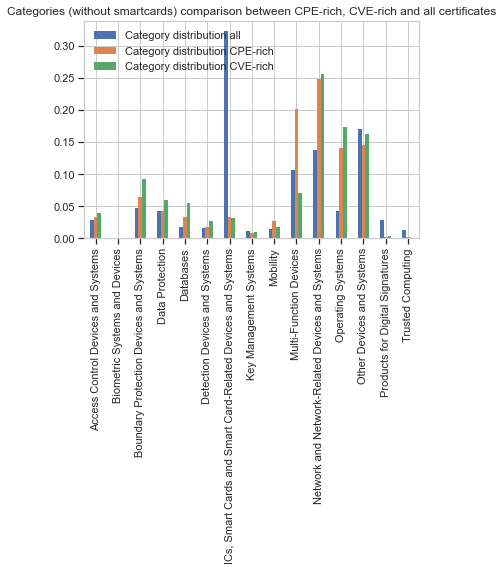

In [12]:
df_cpe_rich = df.loc[~df.cpe_matches.isnull()].copy()
df_cve_rich = df.loc[df.n_cves > 0].copy()

categories_cpe = df_cpe_rich.category.value_counts().sort_index().rename('Category distribution CPE-rich')
categories_cve = df_cve_rich.category.value_counts().sort_index().rename('Category distribution CVE-rich')
categories_all = df.category.value_counts().sort_index().rename('Category distribution all')

categories_merged = pd.concat([categories_all, categories_cpe, categories_cve], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)

categories_merged.plot.bar(title='Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates')
plt.savefig(RESULTS_DIR / "categories.pdf", bbox_inches='tight')

## Plot distribution of years in CPE-rich, CVE-rich, and all certificates

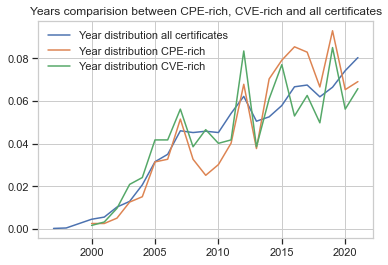

In [13]:
years_cpe = df_cpe_rich.year_from.value_counts().sort_index().rename('Year distribution CPE-rich')
years_cve = df_cve_rich.year_from.value_counts().sort_index().rename('Year distribution CVE-rich')
years_all = df.year_from.value_counts().sort_index().rename('Year distribution all certificates')

years_merged = pd.concat([years_all, years_cpe, years_cve], axis=1)
years_merged = years_merged.div(years_merged.sum(axis=0), axis=1)
years_merged.plot.line(title='Years comparision between CPE-rich, CVE-rich and all certificates')
plt.savefig(RESULTS_DIR / "cve_cpe_certs_time_evolution.pdf", bbox_inches='tight')

## Plot distribution of security levels in CPE-rich, CVE-rich and all certificates

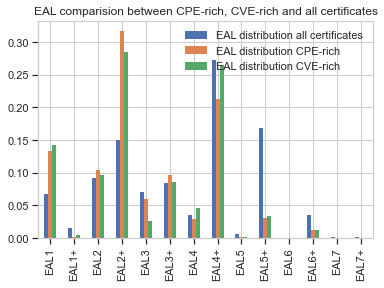

In [14]:
levels_cpe = df_cpe_rich.eal.value_counts().sort_index().rename('EAL distribution CPE-rich')
levels_cve = df_cve_rich.eal.value_counts().sort_index().rename('EAL distribution CVE-rich')
levels_all = df.eal.value_counts().sort_index().rename('EAL distribution all certificates')

levels_merged = pd.concat([levels_all, levels_cpe, levels_cve], axis=1)
levels_merged = levels_merged.div(levels_merged.sum(axis=0), axis=1)
levels_merged.plot.bar(title='EAL comparision between CPE-rich, CVE-rich and all certificates')
plt.savefig(RESULTS_DIR / "eal_distr_all_cpes_cves.pdf", bbox_inches='tight')

## Plot distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates

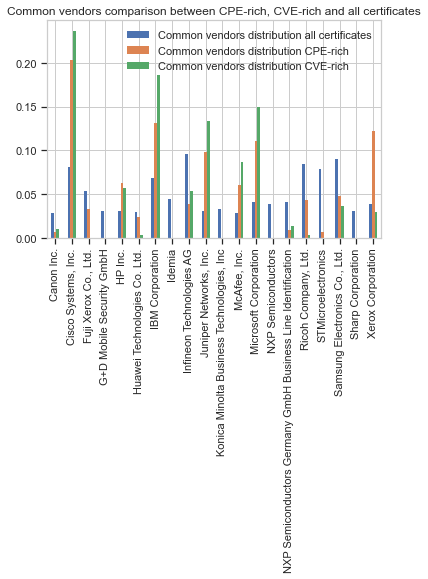

In [15]:
top_manufacturers = list(df.manufacturer.value_counts().head(20).index)
vendors_cpe = df_cpe_rich.loc[df_cpe_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CPE-rich')
vendors_cve = df_cve_rich.loc[df_cve_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CVE-rich')
vendors_all = df.loc[df.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution all certificates')

vendors_merged = pd.concat([vendors_all, vendors_cpe, vendors_cve], axis=1)
vendors_merged = vendors_merged.div(vendors_merged.sum(axis=0), axis=1)
vendors_merged.plot.bar(title='Common vendors comparison between CPE-rich, CVE-rich and all certificates')
plt.savefig(RESULTS_DIR / "top_vendors_vulns.pdf", bbox_inches='tight')

## Correlations between (EAL, SAR) and CVEs

In [16]:
df_corr_all = compute_cve_correlations(df, exclude_vuln_free_certs = False, output_path= RESULTS_DIR / "./all_certs_sar_cve_corr.csv")
df_corr_vuln_rich = compute_cve_correlations(df, exclude_vuln_free_certs = True, output_path= RESULTS_DIR / "./vuln_rich_certs_sar_cve_corr.csv")

  0%|          | 0/130 [00:00<?, ?it/s]

/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c

  0%|          | 0/130 [00:00<?, ?it/s]

/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c

In [17]:
# Shows head of correlations of all certificates
df_corr_all.head()

,n_cves_corr,worst_cve_score_corr,avg_cve_score_corr,support
eal,-0.080595,-0.220579,-0.160127,4893
ADV_FSP,-0.063162,-0.191326,-0.090477,4532
ATE_IND,-0.084558,-0.184895,-0.150147,4343
ATE_FUN,0.026244,-0.107722,-0.074670,3625
ATE_COV,0.024179,-0.072719,-0.075160,3596


In [18]:
# Shows head of correlations of vuln-rich certificates
df_corr_vuln_rich.head()

,n_cves_corr,worst_cve_score_corr,avg_cve_score_corr,support
eal,-0.105202,-0.220579,-0.160127,623
ADV_FSP,-0.061833,-0.191326,-0.090477,610
ATE_IND,-0.128834,-0.184895,-0.150147,604
ALC_CMS,-0.100440,-0.275651,-0.153536,448
ALC_CMC,-0.096846,-0.242216,-0.140715,447


## Time from CVE to maintenance update

The following block computes time from CVE to maintenance update of a certificate. Though, it has some limitations:
- So far we only watch for first CVE related to a certified product (though most of certificates have only one maintenance anyway, if they even have one)
- We assume that a maintance update released *after* (by date comparison) CVE fixes that vulnerability
- The sample size is small. Only 36 certificates have at least one CVE and at least one Maintenance update. Out of those, only 23 certificates have maintenance update that comes after a CVE
- Some stats is shown below, the quantiles in the number of days that it takes to fix the CVE are (267, 382, 562)
- Many certificates have some CVE (167) that is not fixed in a form of a maintenance update

In [19]:
n_unfixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances==0)].shape[0]
n_fixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances>0)].shape[0]
print(f'Number of certificates with >0 CVEs but 0 maintenance reports: {n_unfixed_certs}')
print(f'Number of certificates with >0 CVEs and >0 maintenance reports: {n_fixed_certs}')

df_fixed = compute_maintenances_that_should_fix_vulns(df)
print(df_fixed.loc[~df_fixed.time_to_fix_cve.isnull()]['time_to_fix_cve'].describe())
updates_that_should_fix_vulns_path = RESULTS_DIR / "updates_that_should_fix_vulns"
updates_that_should_fix_vulns_path.mkdir(exist_ok=True)
mu_filenames = move_fixing_mu_to_directory(df_fixed, main_dset.to_pandas(), updates_that_should_fix_vulns_path, RESULTS_DIR / "certs/maintenances/reports/pdf")

Number of certificates with >0 CVEs but 0 maintenance reports: 0
Number of certificates with >0 CVEs and >0 maintenance reports: 36
count                              29
mean     1067 days 19:51:43.448275856
std       887 days 02:05:21.082006944
min                   1 days 00:00:00
25%                 441 days 00:00:00
50%                 874 days 00:00:00
75%                1601 days 00:00:00
max                3752 days 00:00:00
Name: time_to_fix_cve, dtype: object


FileNotFoundError: [Errno 2] No such file or directory: 'results/certs/maintenances/reports/pdf/cert_0159438014a94e93_update_e5388bce562ec8db.pdf'

## Histogram timeline of new vulnerabilities

Shows when vulnerabilities are announced in relation to the date of certification & date of certificate expiration.

*Note*: Some certificates (especially the new ones) don't have their expiration date set yet. These are discarded from the analysis.

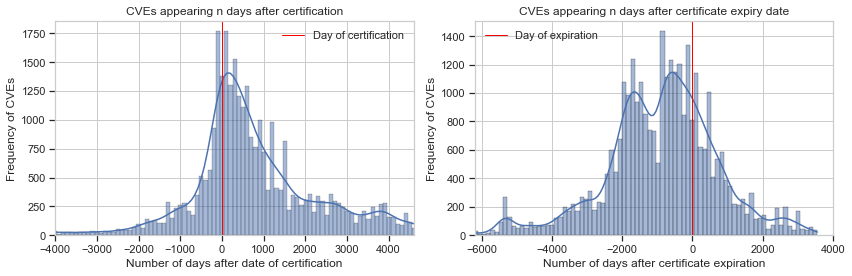

Ratio of CVEs appearing before (or exactly on) certification date: 26.92%
Ratio of CVEs appearing after certification date: 73.08%


In [20]:
exploded_cves = df_cve_rich.explode("related_cves").loc[:, ["related_cves", "not_valid_before", "not_valid_after"]].rename(columns={"related_cves": "cve"})
exploded_cves = exploded_cves.dropna() # <-- Investigate why we have 1056 empty not_valid_after records
exploded_cves["cve_published_date"] = exploded_cves.cve.map(lambda x: cve_dset[x].published_date)

exploded_cves.not_valid_before = exploded_cves.not_valid_before.dt.normalize()
exploded_cves.not_valid_after = exploded_cves.not_valid_after.dt.normalize()
exploded_cves.cve_published_date = exploded_cves.cve_published_date.dt.tz_localize(None).dt.normalize()

exploded_cves["n_days_after_certification"] = (exploded_cves.cve_published_date - exploded_cves.not_valid_before).dt.days
exploded_cves["n_days_after_expiry"] = (exploded_cves.cve_published_date - exploded_cves.not_valid_after).dt.days

plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.autolayout"] = True
figure, axes = plt.subplots(1, 2)

hist = sns.histplot(exploded_cves.n_days_after_certification, kde=True, ax=axes[0])
hist.set(xlim=(-4000,4600), title="CVEs appearing n days after certification", xlabel="Number of days after date of certification", ylabel="Frequency of CVEs")
hist.axvline(0, color="red", linewidth="1", label="Day of certification")
hist.legend(loc="upper right")
# plt.savefig(RESULTS_DIR / "cves_n_days_after_certification.pdf", bbox_inches='tight')
# plt.show()

hist = sns.histplot(exploded_cves.n_days_after_expiry, kde=True, ax=axes[1])
hist.set(xlim=(-6200, 4000), title="CVEs appearing n days after certificate expiry date", xlabel="Number of days after certificate expiration", ylabel="Frequency of CVEs")
hist.axvline(0, color="red", linewidth="1", label="Day of expiration")
hist.legend(loc="upper left")
plt.savefig(RESULTS_DIR / "cves_vs_certificate_lifetime.pdf", bbox_inches='tight')
plt.show()

n_cves = exploded_cves.shape[0]
ratio_before_cert = exploded_cves.loc[exploded_cves.n_days_after_certification <= 0].shape[0] / n_cves
ratio_after_cert = exploded_cves.loc[exploded_cves.n_days_after_certification > 0].shape[0] / n_cves
print(f"Ratio of CVEs appearing before (or exactly on) certification date: {100 * ratio_before_cert:.2f}%")
print(f"Ratio of CVEs appearing after certification date: {100 * ratio_after_cert:.2f}%")

## How many CVE-rich certificates were revoked within <365 days after certification

In [21]:
maybe_revoked = df_cve_rich.loc[~df_cve_rich.not_valid_after.isna(), ["not_valid_before", "not_valid_after", "n_cves", "worst_cve_score", "avg_cve_score", "related_cves"]]
maybe_revoked["validity_n_days"] = (maybe_revoked.not_valid_after - maybe_revoked.not_valid_before).dt.days
maybe_revoked = maybe_revoked.loc[maybe_revoked.validity_n_days < 365]
print(f'How many CVE-rich certificates were revoked in <365 days after certification: {maybe_revoked.shape[0]}')

df_w_validity_dates = df.loc[~df.not_valid_after.isna()].copy()
df_w_validity_dates.loc[:, "validity_n_days"] = (df_w_validity_dates.not_valid_after - df_w_validity_dates.not_valid_before).dt.days
df_w_validity_dates = df_w_validity_dates.loc[df_w_validity_dates.validity_n_days < 365]
print(f'How many certificates were revoked in <365 days after certification: {df_w_validity_dates.shape[0]}')

How many CVE-rich certificates were revoked in <365 days after certification: 3
How many certificates were revoked in <365 days after certification: 39


In [22]:
df_w_validity_dates.loc[:, ["name",  "not_valid_before", "not_valid_after", "validity_n_days", "related_cves"]].sort_values(by="validity_n_days", ascending=False)

,name,not_valid_before,not_valid_after,validity_n_days,related_cves
602f65f51a07adaf,"Brocade Communications Systems, Inc. Brocade D...",2015-03-25,2016-03-21,362,NaN
a7120da6bf4874fa,"DigiSAFE Data Diode model 3282 version 2.2, mo...",2019-06-17,2020-06-10,359,NaN
e2f3a1cdd592ab05,"Cisco 800, 1900, 2900, 3900 Series Integrated ...",2011-07-31,2012-07-20,355,NaN
f410930a2a47d3d0,"Avaya VSP 4000, VSP 7000 and VSP 8000",2017-03-10,2018-02-26,353,NaN
16bdbde359584f99,Xaica-α PLUS ePassport on MTCOS Pro 2.5 with S...,2019-01-25,2019-12-03,312,NaN
0c7ef6c32cbdee47,Xaica-α PLUS ePassport on MTCOS Pro 2.5 with S...,2019-01-25,2019-12-03,312,NaN
3c24bbe7724dbfdd,"McAfee® Email Gateway (MEG) software v7.0.1, r...",2012-10-16,2013-08-21,309,"{CVE-2012-4596, CVE-2012-4583, CVE-2013-6349, ..."
9e0ec9db58b5c8ec,RICOH MP C306Z J-1.01,2016-04-25,2017-02-13,294,NaN
5068c3b7fefae589,bizhub C652 / bizhub C652DS / bizhub C552 / bi...,2010-06-29,2011-04-15,290,NaN
25fcafd838cecd84,bizhub C360 / bizhub C280 / bizhub C220 / bizh...,2010-06-29,2011-04-15,290,NaN


## Scatterplot of CVE severity w.r.t. categories

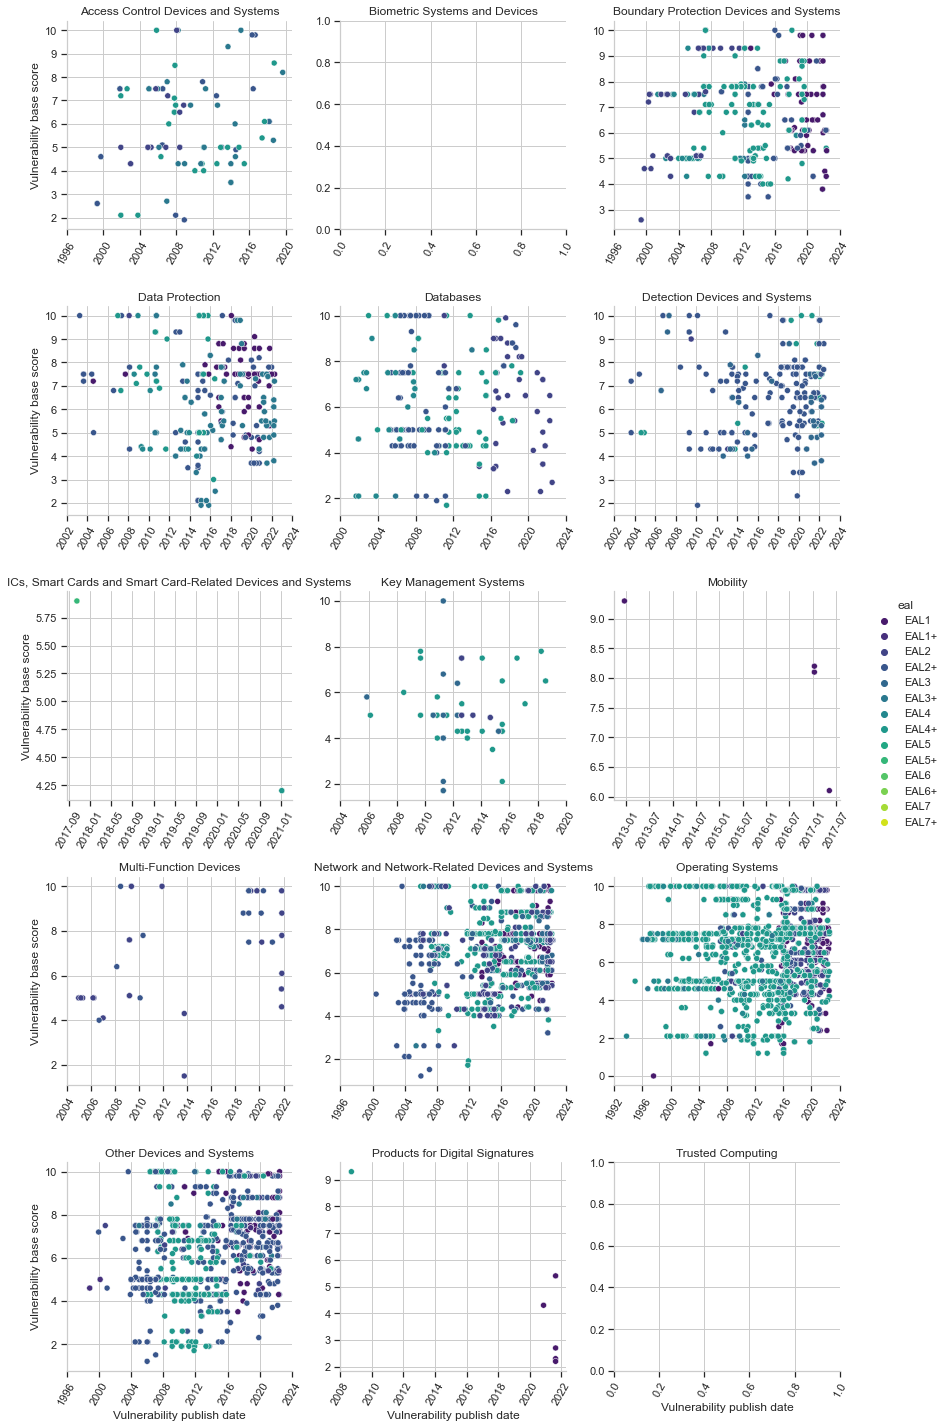

In [23]:
n_cves_top_20_certs = df_cve_rich.n_cves.sort_values(ascending=False).head(20)[-1]
cves = df_cve_rich.loc[(df_cve_rich.n_cves < n_cves_top_20_certs) & (~df_cve_rich.eal.isna()), ["related_cves", "eal", "category"]].explode("related_cves").rename(columns={"related_cves": "cve_id"})
cves["published_date"] = cves.cve_id.map(lambda x: cve_dset[x].published_date).dt.tz_localize(None).dt.normalize()
cves["base_score"] = cves.cve_id.map(lambda x: cve_dset[x].impact.base_score)
cves = cves.drop_duplicates()

g = sns.relplot(data=cves, x="published_date", y="base_score", hue="eal", col="category", col_wrap=3, height=4, kind="scatter", facet_kws={"sharey": False, "sharex": False}, palette="viridis")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=60)
g.set_axis_labels("Vulnerability publish date", "Vulnerability base score")
g.tight_layout()
plt.savefig(RESULTS_DIR / "scatter_category_vs_cves.pdf", bbox_inches='tight')

## Histogram of vulnerability scores per category

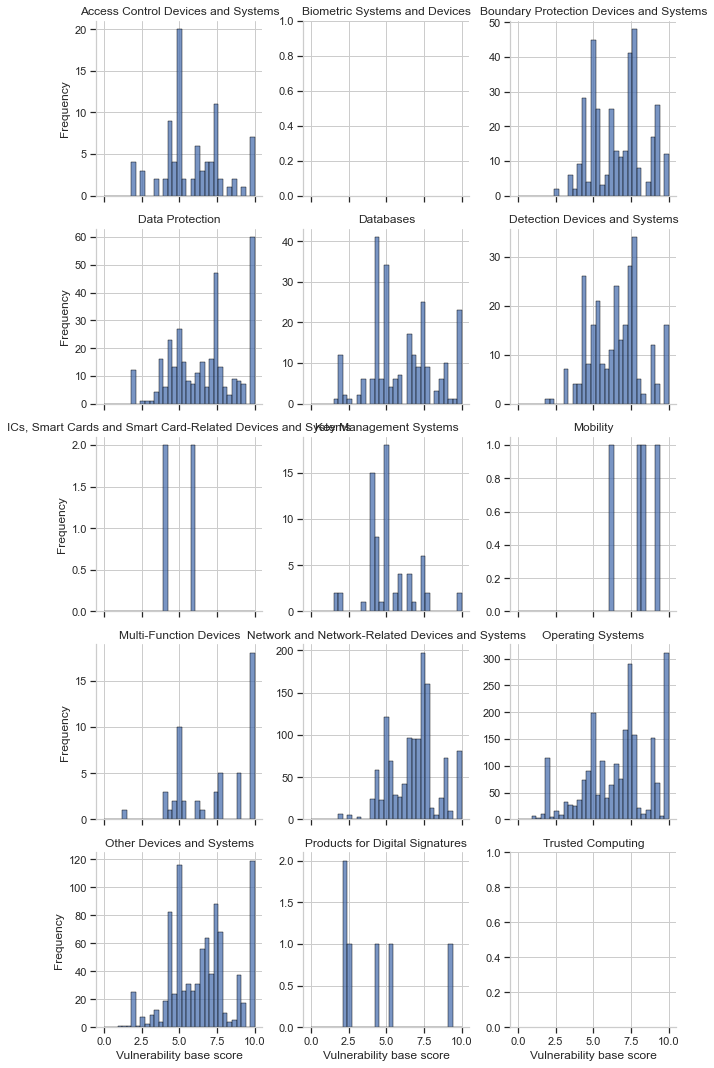

In [24]:
cves = cves.reset_index()  # See https://github.com/mwaskom/seaborn/issues/2733
g = sns.displot(data=cves, x="base_score", col="category", col_wrap=3, height=3, kind="hist", facet_kws={"sharey": False, "sharex": True})
g.set_titles("{col_name}")
# g.set_xticklabels(rotation=60)
g.set_axis_labels("Vulnerability base score", "Frequency")
g.tight_layout()
plt.savefig(RESULTS_DIR / "hist_category_vs_cve.pdf", bbox_inches='tight')

## Protection-profiles vs CVEs

Computes Pearson's correlation coefficient between number of CVEs and binary variable: Has a protection profile (1) or has not a protection profile (0)
Beware, number of supporting certificates may be quite low

In [25]:
df_cve_rich["has_pp"] = df_cve_rich.protection_profiles.isna()
corrs = df_cve_rich.groupby("category")[["n_cves", "has_pp"]].corr().iloc[0::2,-1].droplevel(level=1)
corrs.name = "correlation"
support_counts = df_cve_rich.groupby("category").size()
support_counts.name = "n certs in category"
pp_rich_counts = df_cve_rich.loc[df_cve_rich.has_pp == True].groupby("category").size()
pp_rich_counts.name = "n certs with PP"
pp_n_cves_corr = pd.concat([corrs, support_counts, pp_rich_counts], axis=1)

In [26]:
pp_n_cves_corr

,correlation,n certs in category,n certs with PP
category,,,
Access Control Devices and Systems,0.182036,25,23
Biometric Systems and Devices,NaN,0,0
Boundary Protection Devices and Systems,-0.198400,58,38
Data Protection,0.079948,37,27
Databases,-0.204387,34,26
Detection Devices and Systems,0.004250,17,13
"ICs, Smart Cards and Smart Card-Related Devices and Systems",NaN,20,1
Key Management Systems,0.370422,6,5
Mobility,NaN,11,0


## CWEs in vulnerable certificates

- Study distribution of [CWEs](https://cwe.mitre.org/) in vulnerable certificates. 
- Experiment mainly with distribution across categories and security level. 
- Compare our results with findings from [open-source projects](https://dl.acm.org/doi/pdf/10.1145/3133956.3134072).

In [27]:
cc_df, cwe_df = prepare_cwe_df(df_cve_rich, cve_dset, fine_grained=True)

Filtering 3869 CVEs that have no CWE assigned. This affects 424 certificates
Still left with analysis of 8827 CVEs in 539 certificates.


In [28]:
cc_df

,cert_dgst,eal,cve_id,category,cwe_id
0,ebd276cca70fd723,EAL3+,CVE-2017-1732,Access Control Devices and Systems,CWE-200
1,ebd276cca70fd723,EAL3+,CVE-2015-0235,Access Control Devices and Systems,CWE-787
2,ebd276cca70fd723,EAL3+,CVE-2013-5421,Access Control Devices and Systems,CWE-79
3,ebd276cca70fd723,EAL3+,CVE-2013-5420,Access Control Devices and Systems,CWE-264
4,ebd276cca70fd723,EAL3+,CVE-2013-6745,Access Control Devices and Systems,CWE-79
...,...,...,...,...,...
33431,5f1df5ad8e51ba75,EAL2+,CVE-2004-2320,Other Devices and Systems,CWE-200
33435,ffeef32299d913d6,EAL2,CVE-2008-1592,Other Devices and Systems,CWE-264
33436,ffeef32299d913d6,EAL2,CVE-2008-1130,Other Devices and Systems,CWE-287
33437,ffeef32299d913d6,EAL2,CVE-2009-0439,Other Devices and Systems,CWE-264


In [29]:
cwe_df

,cwe_name,cwe_description,type,child_of,url
cwe_id,,,,,
CWE-1004,Sensitive Cookie Without 'HttpOnly' Flag,The software uses a cookie to store sensitive ...,weakness,{CWE-732},https://cwe.mitre.org/data/definitions/1004.html
CWE-1007,Insufficient Visual Distinction of Homoglyphs ...,The software displays information or identifie...,weakness,{CWE-451},https://cwe.mitre.org/data/definitions/1007.html
CWE-102,Struts: Duplicate Validation Forms,The application uses multiple validation forms...,weakness,"{CWE-694, CWE-1173, CWE-20}",https://cwe.mitre.org/data/definitions/102.html
CWE-1021,Improper Restriction of Rendered UI Layers or ...,The web application does not restrict or incor...,weakness,"{CWE-441, CWE-451, CWE-610}",https://cwe.mitre.org/data/definitions/1021.html
CWE-1022,Use of Web Link to Untrusted Target with windo...,The web application produces links to untruste...,weakness,{CWE-266},https://cwe.mitre.org/data/definitions/1022.html
...,...,...,...,...,...
CWE-994,SFP Secondary Cluster: Tainted Input to Variable,This category identifies Software Fault Patter...,category,NaN,https://cwe.mitre.org/data/definitions/994.html
CWE-995,SFP Secondary Cluster: Feature,This category identifies Software Fault Patter...,category,NaN,https://cwe.mitre.org/data/definitions/995.html
CWE-996,SFP Secondary Cluster: Security,This category identifies Software Fault Patter...,category,NaN,https://cwe.mitre.org/data/definitions/996.html


In [30]:
# Print top-25 CWEs across dataset
top_25_cwes = get_top_n_cwes(cc_df, cwe_df, n_cwes=25)
top_25_cwes

,frequency,cwe_name,cwe_description,url,type
cwe_id,,,,,
CWE-119,3083,Improper Restriction of Operations within the ...,The software performs operations on a memory b...,https://cwe.mitre.org/data/definitions/119.html,weakness
CWE-787,2141,Out-of-bounds Write,"The software writes data past the end, or befo...",https://cwe.mitre.org/data/definitions/787.html,weakness
CWE-20,1881,Improper Input Validation,"The product receives input or data, but it doe...",https://cwe.mitre.org/data/definitions/20.html,weakness
CWE-200,1229,Exposure of Sensitive Information to an Unauth...,The product exposes sensitive information to a...,https://cwe.mitre.org/data/definitions/200.html,weakness
CWE-125,1184,Out-of-bounds Read,"The software reads data past the end, or befor...",https://cwe.mitre.org/data/definitions/125.html,weakness
CWE-416,777,Use After Free,Referencing memory after it has been freed can...,https://cwe.mitre.org/data/definitions/416.html,weakness
CWE-79,772,Improper Neutralization of Input During Web Pa...,The software does not neutralize or incorrectl...,https://cwe.mitre.org/data/definitions/79.html,weakness
CWE-264,749,"Permissions, Privileges, and Access Controls",Weaknesses in this category are related to the...,https://cwe.mitre.org/data/definitions/264.html,category
CWE-269,447,Improper Privilege Management,"The software does not properly assign, modify,...",https://cwe.mitre.org/data/definitions/269.html,weakness


In [31]:
# Store top-10 CWEs into CSVs, do this also per category
CWE_DIR = RESULTS_DIR / "cwes"
CWE_DIR.mkdir(exist_ok=True)
top_25_cwes.to_csv(CWE_DIR / "top_25_cwe_overall.csv")

for cat in cc_df.category.unique():
    get_top_n_cwes(cc_df, cwe_df, category=cat).to_csv(CWE_DIR / (cat + ".csv"))

# Same for EALs
for eal in cc_df.eal.unique():
    get_top_n_cwes(cc_df, cwe_df, eal=eal).to_csv(CWE_DIR / (eal + ".csv"))

In [32]:
# For more coarse-grained description of CVEs, one could use so-called Security Fault Patterns (SFP) clusters.
from sec_certs.utils.pandas import SFPModel
model = SFPModel.from_web()
model.search_cwe(626) # <-- This returns Primary Cluster and Secondary cluster

('Tainted Input', 'SFP Secondary Cluster: Tainted Input to Command')

## CWE evolution in time

the following plot shows how top-10 overall CWEs evolve in time. As can be seen from the plot, the distribution is quite stable except for `CWE-119`. We assume that this can be caused by favoring different CWEs for similar problems, so it does not necessarilly correspond to certain weakness being eliminated recently in the coe, but even this may be the case.

Text(0.5, 1.0, 'CWE prevalence in time')

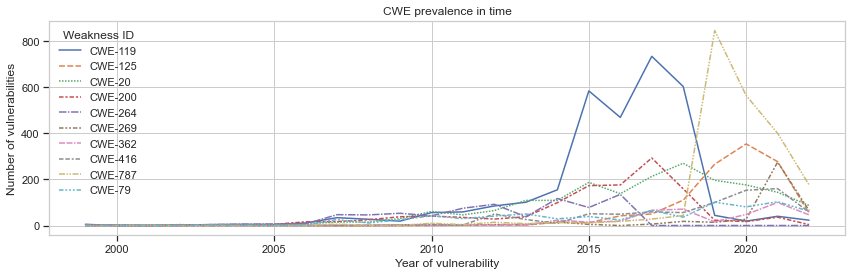

In [33]:
cc_df["vuln_year"] = cc_df.cve_id.map(lambda x: int(x.split("-")[1]))
top_10_cwes = set(get_top_n_cwes(cc_df, cwe_df, n_cwes=10).index.tolist())
top_10_cwes = cc_df.loc[cc_df.cwe_id.isin(top_10_cwes)]
pivot = top_10_cwes.groupby(["vuln_year", "cwe_id"], as_index=False).size().rename(columns={"size": "frequency"}).pivot("vuln_year", "cwe_id", "frequency").fillna(0)
sns.lineplot(data=pivot)
plt.xlabel("Year of vulnerability")
plt.ylabel("Number of vulnerabilities")
plt.legend(title="Weakness ID")
plt.title("CWE prevalence in time")

## Print commands for LaTeX file

In [71]:
def get_n_rules(dct):
    if isinstance(dct, list):
        return len(dct)
    if isinstance(list(dct.values())[0], dict):
        return sum([get_n_rules(x) for x in dct.values()])
    else:
        return sum([len(x) for x in dct.values()])
    
n_regular_expressions = get_n_rules(cc_rules)

n_all_cpes = len(cpe_dset)
n_short_cpes = len([x for x in cpe_dset if x.item_name is not None and not len(x.item_name) > 3])

print(f"\\newcommand{{\\numCCActiveVulnerable}}{{${df_cve_rich.loc[df_cve_rich.status == 'active'].shape[0]}\%$}}")
print(f"\\newcommand{{\\numCCArchivedVulnerable}}{{${df_cve_rich.loc[df_cve_rich.status == 'archived'].shape[0]}\%$}}")
print(f"\\newcommand{{\\fractionCPEShort}}{{${(100 * n_short_cpes / n_all_cpes):.2f}\%$}}  % number CPE strings with <4 characters.")
print(f"\\newcommand{{\\numRegularExpressions}}{{${n_regular_expressions}$}}")


# Data for CWE table
top_10_cwes = get_top_n_cwes(cc_df, cwe_df, n_cwes=10)
for cwe_id, row in top_10_cwes.iterrows():
    print(f"{cwe_id}\t & {row['cwe_name']} \t & {row['frequency']} \\\\")

\newcommand{\numCCActiveVulnerable}{$159\%$}
\newcommand{\numCCArchivedVulnerable}{$464\%$}
\newcommand{\fractionCPEShort}{$4.45\%$}  % number CPE strings with <4 characters.
\newcommand{\numRegularExpressions}{$488$}
CWE-119	 & Improper Restriction of Operations within the Bounds of a Memory Buffer 	 & 3083 \\
CWE-787	 & Out-of-bounds Write 	 & 2141 \\
CWE-20	 & Improper Input Validation 	 & 1881 \\
CWE-200	 & Exposure of Sensitive Information to an Unauthorized Actor 	 & 1229 \\
CWE-125	 & Out-of-bounds Read 	 & 1184 \\
CWE-416	 & Use After Free 	 & 777 \\
CWE-79	 & Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting') 	 & 772 \\
CWE-264	 & Permissions, Privileges, and Access Controls 	 & 749 \\
CWE-269	 & Improper Privilege Management 	 & 447 \\
CWE-362	 & Concurrent Execution using Shared Resource with Improper Synchronization ('Race Condition') 	 & 419 \\
